In [ ]:
!pip install --upgrade protobuf==3.20.3 --quiet
!pip install --upgrade umap-learn==0.5.5 --quiet
!pip install --upgrade scikit-learn==1.3.2 --quiet

import os
os.kill(os.getpid(), 9)   # Auto-restart kernel to apply fixes



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 117.1 MB/s eta 0:00:0000:010:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_recall_fscore_support
)

import os
import time
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
DATA_DIR = "/kaggle/input/saad-3/Microscopic Image Dataset of Plant-Parasitic Nematodes"

# SimCLR augmentations
simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.8,0.8,0.8,0.2)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

full_dataset = datasets.ImageFolder(DATA_DIR, transform=simclr_transform)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))


Train samples: 812
Test samples: 204


In [3]:
class SimCLR(nn.Module):
    def __init__(self, base_encoder, out_dim=128):
        super().__init__()
        self.encoder = base_encoder
        num_ftrs = self.encoder.fc.in_features
        self.encoder.fc = nn.Identity()

        # Projection head
        self.proj = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = self.proj(h)
        return F.normalize(z, dim=1)

resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model = SimCLR(resnet50).to(device)


In [4]:
def nt_xent_loss(z_i, z_j, temperature=0.5):
    N = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)
    sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)
    sim = sim / temperature
    
    labels = torch.arange(N).to(device)
    labels = torch.cat([labels, labels], dim=0)

    mask = torch.eye(2*N, dtype=bool).to(device)
    sim = sim.masked_fill(mask, -9e15)

    return F.cross_entropy(sim, labels)


In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
epochs = 50

loss_history = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, _ in train_loader:
        images = images.to(device)
        xi, xj = images, images  # two views

        zi = model(xi)
        zj = model(xj)

        loss = nt_xent_loss(zi, zj)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_loss = total_loss / len(train_loader)
    loss_history.append(epoch_loss)

    print(f"Epoch {epoch+1}/{epochs} Loss: {epoch_loss:.4f}")

torch.save(model.encoder.state_dict(), "frozen_encoder.pt")


Epoch 1/50 Loss: 4500000011149942.0000
Epoch 2/50 Loss: 4500000011149942.0000
Epoch 3/50 Loss: 4500000011149942.0000
Epoch 4/50 Loss: 4500000011149942.0000
Epoch 5/50 Loss: 4500000011149942.0000
Epoch 6/50 Loss: 4500000011149942.0000
Epoch 7/50 Loss: 4500000011149942.0000
Epoch 8/50 Loss: 4500000011149942.0000
Epoch 9/50 Loss: 4500000011149942.0000
Epoch 10/50 Loss: 4500000011149942.0000
Epoch 11/50 Loss: 4500000011149942.0000
Epoch 12/50 Loss: 4500000011149942.0000
Epoch 13/50 Loss: 4500000011149942.0000
Epoch 14/50 Loss: 4500000011149942.0000
Epoch 15/50 Loss: 4500000011149942.0000
Epoch 16/50 Loss: 4500000011149942.0000
Epoch 17/50 Loss: 4500000011149942.0000
Epoch 18/50 Loss: 4500000011149942.0000
Epoch 19/50 Loss: 4500000011149942.0000
Epoch 20/50 Loss: 4500000011149942.0000
Epoch 21/50 Loss: 4500000011149942.0000
Epoch 22/50 Loss: 4500000011149942.0000
Epoch 23/50 Loss: 4500000011149942.0000
Epoch 24/50 Loss: 4500000011149942.0000
Epoch 25/50 Loss: 4500000011149942.0000
Epoch 26/

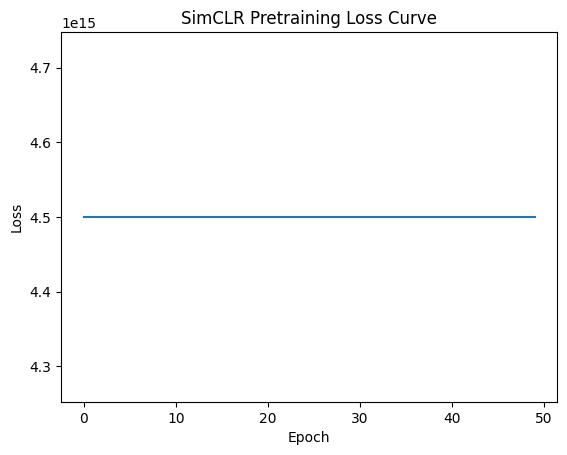

In [6]:
plt.plot(loss_history)
plt.title("SimCLR Pretraining Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [7]:
for p in model.encoder.parameters():
    p.requires_grad = False

def extract_features(loader):
    model.encoder.eval()
    feats, labels = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            f = model.encoder(imgs).cpu()
            feats.append(f)
            labels.append(lbls)
    return torch.cat(feats).numpy(), torch.cat(labels).numpy()

X_train, y_train = extract_features(train_loader)
X_test, y_test = extract_features(test_loader)

print("Feature shape:", X_train.shape)


Feature shape: (812, 2048)


In [8]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.16666666666666666
[[ 4  2  0  5  2  7  1  1  1  2]
 [ 1  5  0  1 10  5  0  2  1  1]
 [ 0  0  0  0  0  2  0  0  0  0]
 [ 4  3  0  2  4  4  3  0  0  4]
 [ 2  0  0  4  8  9  2  0  0  3]
 [ 1  8  0  8  6 11  3  0  0  6]
 [ 5  8  0  5  3  4  1  0  1  1]
 [ 1  2  0  1  0  0  0  0  0  1]
 [ 1  2  0  1  1  0  0  0  0  2]
 [ 0  2  0  2  3  4  0  1  1  3]]
              precision    recall  f1-score   support

           1       0.21      0.16      0.18        25
           2       0.16      0.19      0.17        26
           3       0.00      0.00      0.00         2
           4       0.07      0.08      0.08        24
           5       0.22      0.29      0.25        28
           6       0.24      0.26      0.25        43
           7       0.10      0.04      0.05        28
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         7
          10       0.13      0.19      0.15        16

    accuracy                           0.17

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

In [9]:
from sklearn.neighbors import KNeighborsClassifier

for k in [1, 5, 20]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    print(f"k={k} Accuracy:", accuracy_score(y_test, pred))


k=1 Accuracy: 0.12254901960784313
k=5 Accuracy: 0.14705882352941177
k=20 Accuracy: 0.17647058823529413


2025-12-02 22:19:52.946229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764713992.967641     684 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764713992.974152     684 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


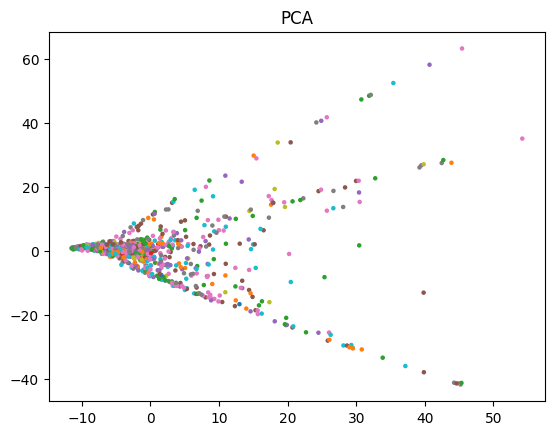

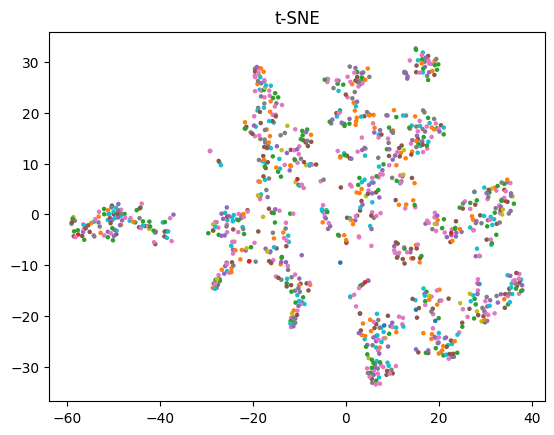

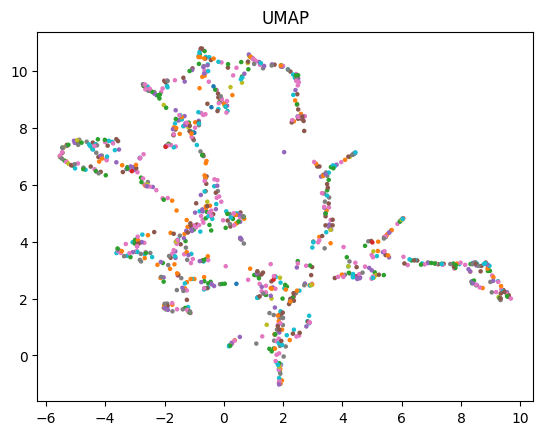

Silhouette Score: -0.17407319


In [10]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.metrics import silhouette_score

X_emb = np.concatenate([X_train, X_test])
y_emb = np.concatenate([y_train, y_test])

# PCA
pca = PCA(n_components=2)
pca_res = pca.fit_transform(X_emb)

plt.scatter(pca_res[:,0], pca_res[:,1], c=y_emb, s=5, cmap='tab10')
plt.title("PCA")
plt.show()

# TSNE
tsne = TSNE(n_components=2)
tsne_res = tsne.fit_transform(X_emb)

plt.scatter(tsne_res[:,0], tsne_res[:,1], c=y_emb, s=5, cmap='tab10')
plt.title("t-SNE")
plt.show()

# UMAP
um = umap.UMAP(n_components=2)
um_res = um.fit_transform(X_emb)

plt.scatter(um_res[:,0], um_res[:,1], c=y_emb, s=5, cmap='tab10')
plt.title("UMAP")
plt.show()

# Silhouette
print("Silhouette Score:", silhouette_score(X_emb, y_emb))


In [11]:
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='weighted'
)

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)


Precision: 0.15786494892144756
Recall: 0.16666666666666666
F1: 0.1583150870999006


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


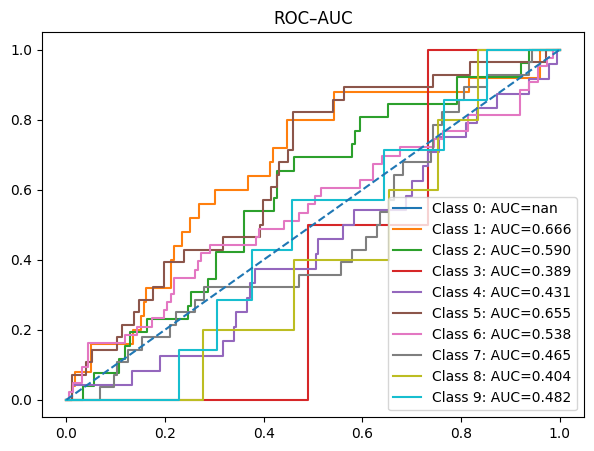

In [12]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

num_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=list(range(num_classes)))

y_scores = clf.predict_proba(X_test)

plt.figure(figsize=(7,5))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:,i], y_scores[:,i])
    auc_val = auc(fpr,tpr)
    plt.plot(fpr, tpr, label=f"Class {i}: AUC={auc_val:.3f}")

plt.plot([0,1],[0,1],'--')
plt.title("ROC–AUC")
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

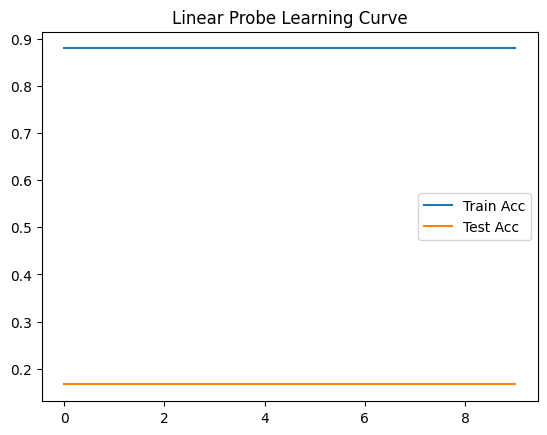

In [13]:
train_acc_hist = []
test_acc_hist = []

for _ in range(10):
    clf = LogisticRegression(max_iter=2000)
    clf.fit(X_train, y_train)
    train_acc_hist.append(clf.score(X_train, y_train))
    test_acc_hist.append(clf.score(X_test, y_test))

plt.plot(train_acc_hist, label="Train Acc")
plt.plot(test_acc_hist, label="Test Acc")
plt.legend()
plt.title("Linear Probe Learning Curve")
plt.show()


In [14]:
!pip install thop > /dev/null
from thop import profile

dummy = torch.randn(1,3,224,224).to(device)
macs, params = profile(model.encoder, inputs=(dummy,))
print("GFLOPs:", macs/1e9)
print("Params (M):", params/1e6)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libcugraph-cu12 25.6.0 requires libraft-cu12==25.6.*, but you have libraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires pylibraft-cu12==25.6.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires rmm-cu12==25.6.*, but you have rmm-cu12 25.2.0 which is incompatible.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
G

1% labels → Accuracy: 0.0588
5% labels → Accuracy: 0.1324
10% labels → Accuracy: 0.1275
25% labels → Accuracy: 0.1324
50% labels → Accuracy: 0.1814


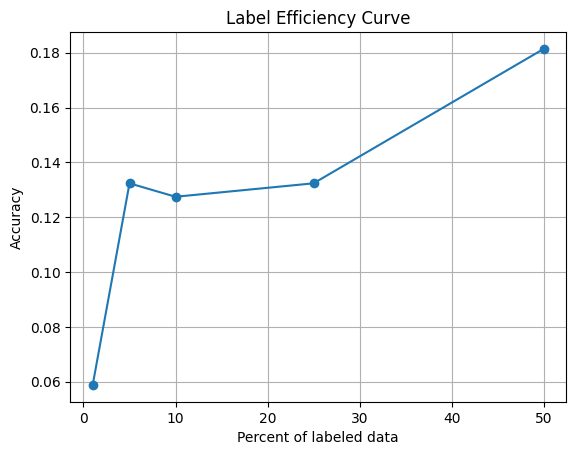

In [17]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

ratios = [0.01, 0.05, 0.10, 0.25, 0.50]
results = {}

X = X_train
y = y_train

unique_classes = np.unique(y)

for r in ratios:
    X_small = []
    y_small = []

    for cls in unique_classes:
        cls_idx = np.where(y == cls)[0]
        n_samples = max(1, int(len(cls_idx) * r))

        chosen = np.random.choice(cls_idx, n_samples, replace=False)
        X_small.append(X[chosen])
        y_small.append(y[chosen])

    X_small = np.vstack(X_small)
    y_small = np.hstack(y_small)

    clf_eff = LogisticRegression(max_iter=3000)
    clf_eff.fit(X_small, y_small)

    acc = clf_eff.score(X_test, y_test)
    results[r] = acc
    print(f"{int(r*100)}% labels → Accuracy: {acc:.4f}")

# Plotting
plt.plot([r*100 for r in ratios], list(results.values()), marker='o')
plt.title("Label Efficiency Curve")
plt.xlabel("Percent of labeled data")
plt.ylabel("Accuracy")
plt.grid()
plt.show()


In [19]:
start = time.time()
clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)
train_time = time.time() - start

start = time.time()
clf.predict(X_test)
test_time = time.time() - start

print("Train Time:", train_time)
print("Test Time:", test_time)


Train Time: 25.060458183288574
Test Time: 0.002528667449951172


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
